## Лабораторная работа № 3. Exploratory Data Analysis и линейная регрессия


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а также привыкнем к основным понятиям машинного обучения.

<strong style="color: red">Внимание!</strong> В этом ноутбуке используется библиотека `ipyleaflet`. Чтобы ее установить так, чтобы она работала, нужно совершить 2 простых шага:

In [2]:
%%bash
pip3 install ipyleaflet
pip3 install haversine
jupyter nbextension enable --py --sys-prefix ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Enabling notebook extension jupyter-leaflet/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


После этого перезапустите сессию (не `Restart Kernel`, а нажмите `Ctrl+C` в терминале, где вы запускали ноутбук, и запустите заново). Лучше это сделать сразу, чтобы потом не пришлось прерывать сессию и терять промежуточные результаты работы. Если все сделано правильно, вы должны увидеть карту Москвы, выполнив ячейку ниже:

In [3]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

In [4]:
#Map(center=(55.7522200, 37.6155600), zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## Часть 0.

**Задание 1.**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [6]:
data = pd.read_csv("drive/MyDrive/train.csv")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [8]:
data=data.drop(columns="dropoff_datetime")
data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Разбейте выборку на обучающую и тестовую в отношении 7:3.

In [10]:
from sklearn.model_selection import train_test_split
data = data.drop(columns=["id"])
y=data['trip_duration']
X=data.drop(columns='trip_duration')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [11]:
#sns.distplot(y_train)
#plt.xlim(-20000,90000)

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

У логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашим выборкам колонки `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке:

In [12]:
y_train['log_trip_duration']=np.log1p(y_train)
y_test['log_trip_duration']=np.log1p(y_test)
#sns.distplot(y_train['log_trip_duration'])

## Часть 1. Изучаем `pickup_datetime`

**Задание 2.**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [13]:
#plot=sns.countplot(y=data['pickup_datetime'].dt.to_period("D"))
#plot.figure.set_size_inches(30, 50)

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [14]:
#sns.relplot(x=data['pickup_datetime'].dt.dayofweek,y=data['pickup_datetime'].dt.dayofweek.value_counts(),kind="line")
#sns.relplot(x=data['pickup_datetime'].dt.hour,y=data['pickup_datetime'].dt.hour.value_counts(),kind="line")

**Задание 3.**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [15]:
#sns.relplot(x=data['pickup_datetime'].dt.hour,y=data['pickup_datetime'].dt.hour.value_counts(),hue=data['pickup_datetime'].dt.month,kind="line")
#sns.relplot(x=data['pickup_datetime'].dt.hour,y=data['pickup_datetime'].dt.hour.value_counts(),hue=data['pickup_datetime'].dt.dayofweek,kind="line")

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4.**. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [16]:
#sns.relplot(x=X_train['pickup_datetime'].dt.dayofweek,y=X_train['pickup_datetime'].dt.dayofweek.value_counts(),hue=y_train['log_trip_duration'].mean() ,kind="line")
#sns.relplot(x=X_train['pickup_datetime'].dt.dayofyear,y=X_train['pickup_datetime'].dt.dayofyear.value_counts(),hue=y_train['log_trip_duration'].mean() ,kind="line")
#sns.relplot(x=X_train['pickup_datetime'].dt.hour,y=X_train['pickup_datetime'].dt.hour.value_counts(),hue=y_train['log_trip_duration'].mean() ,kind="line")

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [17]:
data["Day_of_week"]=data["pickup_datetime"].dt.dayofweek

data["Month"]=data["pickup_datetime"].dt.month

data["Hour"]=data["pickup_datetime"].dt.hour

data["Anomal"]=np.where(((data['pickup_datetime'].dt.to_period("D")=="2016-01-23")|(data['pickup_datetime'].dt.to_period("D")=="2016-01-24")),True,False)

data["Day_of_year"]=data["pickup_datetime"].dt.dayofyear

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5.**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

def RidgeRegression(data, categorical, numeric):
  y=data['log_trip_duration']
  X=data.drop(columns='log_trip_duration')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
  pd.isnull(data).any()
  column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
  ])

  pipeline = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('regression', Ridge())
  ])
  model  = pipeline.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=True))
  return model, X_train, X_test, y_train, y_test

In [19]:
data['log_trip_duration']=np.log1p(data['trip_duration'])
categorical=['Day_of_week','Month','Hour','Anomal','Day_of_year']
numeric=[]
model, X_train, X_test, y_train, y_test = RidgeRegression(data, categorical, numeric);

Test RMSE = 0.6185


## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Подготовлена функция, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [20]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [21]:
#show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [22]:
#show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6.**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [23]:
from haversine import haversine, Unit

data['haversine']=data.apply(lambda row:haversine((row['pickup_latitude'],row['pickup_longitude']),(row['dropoff_latitude'],row['dropoff_longitude'])),axis=1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [24]:
data['log_haversine']=np.log1p(data['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [25]:
haversinedata=['haversine', 'log_haversine']
corica=data[haversinedata].corrwith(y_train).sort_values(ascending=False)


In [26]:
#plot = sns.barplot(y=corica.index, x=corica)
#plot.figure.set_size_inches(15, 10)

**Задание 7.** Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [27]:
data['srspeed']=data['haversine']/data['trip_duration']

In [28]:
#hist=sns.displot(data['srspeed'],kde=True)
#hist.figure.set_size_inches(30, 20)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [29]:
q1=data['srspeed'].quantile(0.25)
q3=data['srspeed'].quantile(0.75)
iqr=q3-q1
data.srspeed[(data['srspeed'] >= (q3+1.5*iqr))|(data['srspeed'] <= (q1-1.5*iqr))]=np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
#hist=sns.displot (data['srspeed'],kde=True)
#hist.figure.set_size_inches(30, 20)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [31]:
fortask=['Day_of_week',"Hour","srspeed"]
heatmap1_data = pd.pivot_table(data[fortask], values='srspeed', 
                     index=['Day_of_week'], 
                     columns='Hour')


In [32]:
#sns.heatmap(heatmap1_data)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [33]:
data=data.drop(columns='srspeed')

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [34]:
data['freeroad']=np.where(data['Hour']<=7,True,False)

In [35]:
data1 = data

In [36]:
print(data1[['pickup_latitude','dropoff_latitude']])

         pickup_latitude  dropoff_latitude
0              40.767937         40.765602
1              40.738564         40.731152
2              40.763939         40.710087
3              40.719971         40.706718
4              40.793209         40.782520
...                  ...               ...
1458639        40.745522         40.740170
1458640        40.747379         40.796547
1458641        40.768799         40.707371
1458642        40.749062         40.757107
1458643        40.781750         40.790585

[1458644 rows x 2 columns]


In [37]:
# La Guardia
#LaGuardia_latitud_1 = 40.767912878348746
#LaGuardia_longitude_1 =-73.88493229565299
#LaGuardia_latitud_2 = 40.78052042620125
#LaGuardia_longitude_2 = -73.85512397468852
#  John F Kennedy
#JohnFKennedy_latitud_1 = 40.63480050205082
#JohnFKennedy_longitude_1 =-73.80175338270683
#JohnFKennedy_latitud_2 = 40.656565472301224
#JohnFKennedy_longitude_2 = -73.77540300997829

#def Airports(row):
#  newRow = pd.DataFrame() 
#  if (row['pickup_latitude'] >=LaGuardia_latitud_1 and row['pickup_latitude'] <=LaGuardia_latitud_2 and  row['pickup_longitude'] >=LaGuardia_longitude_1 and row['pickup_longitude'] <=LaGuardia_longitude_2 ):
#    newRow["1"]=1
#  else:
#    newRow["1"]=0
#  if (row['dropoff_latitude'] >=LaGuardia_latitud_1 and row['dropoff_latitude'] <=LaGuardia_latitud_2 and  row['dropoff_longitude'] >=LaGuardia_longitude_1 and row['dropoff_longitude'] <=LaGuardia_longitude_2 ):
#    newRow["2"]=1
#  else:
#    newRow["2"]=0
#  if (row['pickup_latitude'] >=JohnFKennedy_latitud_1 and row['pickup_latitude'] <=JohnFKennedy_latitud_2 and  row['pickup_longitude'] >=JohnFKennedy_longitude_1 and row['pickup_longitude'] <=JohnFKennedy_longitude_2 ):
#    newRow["3"]=1
#  else:
#    newRow["3"]=0
#  if (row['dropoff_latitude'] >=JohnFKennedy_latitud_1 and row['dropoff_latitude'] <=JohnFKennedy_latitud_2 and  row['dropoff_longitude'] >=JohnFKennedy_longitude_1 and row['dropoff_longitude'] <=JohnFKennedy_longitude_2 ):
#    newRow["4"]=1
#  else:
#    newRow["4"]=0
#  return newRow
#data1['Beg_LaGuardia'] = data1.apply(lambda row: 1 if (row['pickup_latitude'] >=LaGuardia_latitud_1 and row['pickup_latitude'] <=LaGuardia_latitud_2 and  row['pickup_longitude'] >=LaGuardia_longitude_1 and row['pickup_longitude'] <=LaGuardia_longitude_2 ) else 0 , axis=1)
#data1['End_LaGuardia'] = data1.apply(lambda row: 1 if (row['dropoff_latitude'] >=LaGuardia_latitud_1 and row['dropoff_latitude'] <=LaGuardia_latitud_2 and  row['dropoff_longitude'] >=LaGuardia_longitude_1 and row['dropoff_longitude'] <=LaGuardia_longitude_2 ) else 0 , axis=1)

#data1['Beg_JohnFKennedy'] = data1.apply(lambda row: 1 if (row['pickup_latitude'] >=JohnFKennedy_latitud_1 and row['pickup_latitude'] <=JohnFKennedy_latitud_2 and  row['pickup_longitude'] >=JohnFKennedy_longitude_1 and row['pickup_longitude'] <=JohnFKennedy_longitude_2 ) else 0 , axis=1)
#data1['End_JohnFKennedy'] = data1.apply(lambda row: 1 if (row['dropoff_latitude'] >=JohnFKennedy_latitud_1 and row['dropoff_latitude'] <=JohnFKennedy_latitud_2 and  row['dropoff_longitude'] >=JohnFKennedy_longitude_1 and row['dropoff_longitude'] <=JohnFKennedy_longitude_2 ) else 0 , axis=1)
#data1[['Beg_LaGuardia','End_LaGuardia','End_LaGuardia','Beg_JohnFKennedy','End_JohnFKennedy']] = data1.apply(Airports,axis=1)
#print(data[data['Beg_LaGuardia']==1].shape[0])

**Задание 8.** Как уже было замечено выше, на карте выделяются две точки - аэропорты La Guardia и John F Kennedy. Для каждого из аэропортов добавьте в выборки два признака: началась ли поездка из этого аэропорта и закончилась ли поездка в этом аэропорте.

In [38]:
# La Guardia
LaGuardia_latitud_1 = 40.767912878348746
LaGuardia_longitude_1 =-73.88493229565299
LaGuardia_latitud_2 = 40.78052042620125
LaGuardia_longitude_2 = -73.85512397468852
#  John F Kennedy
JohnFKennedy_latitud_1 = 40.63480050205082
JohnFKennedy_longitude_1 =-73.80175338270683
JohnFKennedy_latitud_2 = 40.656565472301224
JohnFKennedy_longitude_2 = -73.77540300997829

data['Beg_LaGuardia'] = data1.apply(lambda row: 1 if (row['pickup_latitude'] >=LaGuardia_latitud_1 and row['pickup_latitude'] <=LaGuardia_latitud_2 and  row['pickup_longitude'] >=LaGuardia_longitude_1 and row['pickup_longitude'] <=LaGuardia_longitude_2 ) else 0 , axis=1)
data['End_LaGuardia'] = data1.apply(lambda row: 1 if (row['dropoff_latitude'] >=LaGuardia_latitud_1 and row['dropoff_latitude'] <=LaGuardia_latitud_2 and  row['dropoff_longitude'] >=LaGuardia_longitude_1 and row['dropoff_longitude'] <=LaGuardia_longitude_2 ) else 0 , axis=1)

data['Beg_JohnFKennedy'] = data1.apply(lambda row: 1 if (row['pickup_latitude'] >=JohnFKennedy_latitud_1 and row['pickup_latitude'] <=JohnFKennedy_latitud_2 and  row['pickup_longitude'] >=JohnFKennedy_longitude_1 and row['pickup_longitude'] <=JohnFKennedy_longitude_2 ) else 0 , axis=1)
data['End_JohnFKennedy'] = data1.apply(lambda row: 1 if (row['dropoff_latitude'] >=JohnFKennedy_latitud_1 and row['dropoff_latitude'] <=JohnFKennedy_latitud_2 and  row['dropoff_longitude'] >=JohnFKennedy_longitude_1 and row['dropoff_longitude'] <=JohnFKennedy_longitude_2 ) else 0 , axis=1)

#print(data[data['Beg_LaGuardia']==1].shape[0])

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [39]:
#sns.boxplot(data=data, x='Beg_LaGuardia',y='log_trip_duration')

In [40]:
#sns.boxplot(data=data, x='End_LaGuardia',y='log_trip_duration')

In [41]:
#sns.boxplot(data=data, x='Beg_JohnFKennedy',y='log_trip_duration')

In [42]:
#sns.boxplot(data=data, x='End_JohnFKennedy',y='log_trip_duration')

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9.** Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [43]:
#sns.boxplot(X_train['pickup_latitude'])


In [44]:
#sns.boxplot(X_train['pickup_longitude'])

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cellBegin = -1
        self.cellEnd = -1

    def Latitude(self,latitude):
        if(latitude>=40 and latitude<41):
          return 0
        elif (latitude>=41 and latitude<=42):
          return 1
        else:
          return -1
    
    def Longitude(self,longitude):
        if(longitude>=-75 and longitude<-74):
          return 0
        elif (longitude>=-74 and longitude<-73):
          return 1
        elif (longitude>=-73 and longitude<=-72):
          return 2
        else:
          return -1

    def CellBegin(self, data):
        collumn = self.Latitude(data["pickup_latitude"])
        row = self.Longitude(data["pickup_longitude"])
        if(collumn == -1 or row == -1):
          return -1;
        else:
          return collumn + row*2+1

    def CellEnd(self, data):
        collumn = self.Latitude(data["dropoff_latitude"])
        row = self.Longitude(data["dropoff_longitude"])
        if(collumn == -1 or row == -1):
          return -1;
        else:
          return collumn + row*2+1

    def fit(self,  X, y=None):
        return self

    def transform(self, X, y=None):
        X["cellBegin"] = data.apply(self.CellBegin, axis =1)
        X["cellEnd"] = data.apply(self.CellEnd, axis =1)
        return X

In [46]:
pipeline = Pipeline([
    ('mapgrid', MapGridTransformer())
])

model9 = pipeline.fit_transform(data)

In [47]:
model9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1458644 non-null  int64         
 1   pickup_datetime     1458644 non-null  datetime64[ns]
 2   passenger_count     1458644 non-null  int64         
 3   pickup_longitude    1458644 non-null  float64       
 4   pickup_latitude     1458644 non-null  float64       
 5   dropoff_longitude   1458644 non-null  float64       
 6   dropoff_latitude    1458644 non-null  float64       
 7   store_and_fwd_flag  1458644 non-null  object        
 8   trip_duration       1458644 non-null  int64         
 9   Day_of_week         1458644 non-null  int64         
 10  Month               1458644 non-null  int64         
 11  Hour                1458644 non-null  int64         
 12  Anomal              1458644 non-null  bool          
 13  Day_of_year 

**Задание 10.** Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, численные признаки отмасштабируйте.

In [48]:
categorical=['Day_of_week','Month','Hour','Anomal','Day_of_year', "freeroad", "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
model, X_train, X_test, y_train, y_test = RidgeRegression(model9,categorical,numeric)

Test RMSE = 0.2367


## Часть 3. Изучаем оставшиеся признаки

**Задание 11.** У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [49]:
print(len(np.unique(model9["vendor_id"])))
print(len(np.unique(model9["passenger_count"])))
print(len(np.unique(model9["store_and_fwd_flag"])))

2
10
2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

In [50]:
#sns.boxplot(data=model9, x='vendor_id',y='log_trip_duration')

In [51]:
#sns.boxplot(data=model9, x='passenger_count',y='log_trip_duration')

In [52]:
#sns.boxplot(data=model9, x='store_and_fwd_flag',y='log_trip_duration')

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [53]:
def Vendor_ID(row):
  if(row["vendor_id"]==1):
    return 0
  else:
    return 1

def Store_and_fwd_flag(row):
  if(row["store_and_fwd_flag"]=="N"):
    return 0
  else:
    return 1

model9["vendor_id"] = data.apply(Vendor_ID, axis =1)
model9["store_and_fwd_flag"] = data.apply(Store_and_fwd_flag, axis =1)

In [54]:
model9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1458644 non-null  int64         
 1   pickup_datetime     1458644 non-null  datetime64[ns]
 2   passenger_count     1458644 non-null  int64         
 3   pickup_longitude    1458644 non-null  float64       
 4   pickup_latitude     1458644 non-null  float64       
 5   dropoff_longitude   1458644 non-null  float64       
 6   dropoff_latitude    1458644 non-null  float64       
 7   store_and_fwd_flag  1458644 non-null  int64         
 8   trip_duration       1458644 non-null  int64         
 9   Day_of_week         1458644 non-null  int64         
 10  Month               1458644 non-null  int64         
 11  Hour                1458644 non-null  int64         
 12  Anomal              1458644 non-null  bool          
 13  Day_of_year 

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12.** Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [55]:
categorical=['Day_of_week','Month','Hour','Anomal','Day_of_year', "freeroad", "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd", "vendor_id", "store_and_fwd_flag"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', "passenger_count",'log_haversine']
model, X_train, X_test, y_train, y_test = RidgeRegression(model9,categorical,numeric)


Test RMSE = 0.2365


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [56]:
model9=model9.drop(columns='vendor_id')
model9=model9.drop(columns='store_and_fwd_flag')
model9=model9.drop(columns='passenger_count')

## Часть 4. Улучшаем модель

**Задание 13.** В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


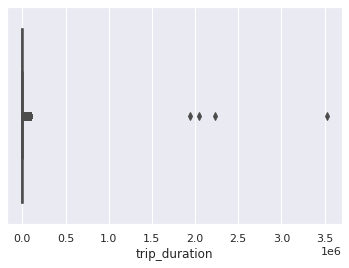

In [57]:
sns.boxplot(model9["trip_duration"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


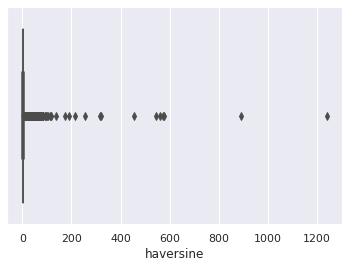

In [58]:
sns.boxplot(data["haversine"])

In [59]:
model9["trip_duration"].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [60]:
model9["haversine"].describe()

count    1.458644e+06
mean     3.440869e+00
std      4.296544e+00
min      0.000000e+00
25%      1.231838e+00
50%      2.093720e+00
75%      3.875343e+00
max      1.240910e+03
Name: haversine, dtype: float64

In [61]:
q25T = model9['trip_duration'].quantile(q=0.25)
q75T = model9['trip_duration'].quantile(q=0.75)

Q25T = q25T - 1.5 * (q75T-q25T)
Q75T = q75T + 1.5 * (q75T-q25T)
print(Q25T)
print(Q75T)

q25 = model9['haversine'].quantile(q=0.25)
q75 = model9['haversine'].quantile(q=0.75)

Q25 = q25 - 1.5 * (q75-q25)
Q75 = q75 + 1.5 * (q75-q25)
print(Q25)
print(Q75)

-620.0
2092.0
-2.733418487383387
7.840599526151175


In [62]:
model9Mean1 = model9["trip_duration"].mean()
model9Mean2 = model9["haversine"].mean()
def Trip_duration(row):
    if(row["trip_duration"]>Q75T or row["trip_duration"]<Q25T):
      return model9Mean1
    else:
      return row["trip_duration"]
    
def Haversine(row):   
    if(row["haversine"]>Q25):
      return model9Mean2
    else:
      return row["haversine"]
    

model9["trip_duration"] = model9.apply(Trip_duration, axis =1)
model9["haversine"] = model9.apply(Haversine, axis =1)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [63]:
test1 = 0
test2 = 0
for test0 in model9["End_JohnFKennedy"]:
  if(int(test0)==0):
    test1+=1
  else:
    test2+=1
print(test1)
print(test2)

1446625
12019


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [64]:
pd.isnull(model9).any()
#print(model9Mean1)

pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
trip_duration        False
Day_of_week          False
Month                False
Hour                 False
Anomal               False
Day_of_year          False
log_trip_duration    False
haversine            False
log_haversine        False
freeroad             False
Beg_LaGuardia        False
End_LaGuardia        False
Beg_JohnFKennedy     False
End_JohnFKennedy     False
cellBegin            False
cellEnd              False
dtype: bool

In [65]:
categorical=['Day_of_week','Month','Hour','Anomal','Day_of_year', "freeroad", "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
model, X_train, X_test, y_train, y_test = RidgeRegression(model9,categorical,numeric)

Test RMSE = 0.2367


**Задание 14.** После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [66]:
model10 = model9

In [67]:
categorical=['Day_of_week','Month','Hour','Anomal','Day_of_year', "freeroad", "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
model, X_train, X_test, y_train, y_test = RidgeRegression(model10,categorical,numeric)

Test RMSE = 0.2367


In [68]:
categorical=['Day_of_week','Month','Hour','Anomal','Day_of_year', "freeroad", "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
y=model10['log_trip_duration']
X=model10.drop(columns='log_trip_duration')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
pd.isnull(model10).any()
print(np.size(model10, 1))
column_transformer = ColumnTransformer([
  ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
  ('scaling', StandardScaler(), numeric)
])
onehotencoder = OneHotEncoder()
data_new = onehotencoder.fit_transform(model10[categorical])
print(np.size(data_new, 1))
#numOfColumns = np.size(column_transformer, 1)
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])
model  = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=True))
  

21
245
Test RMSE = 0.2367


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Стало ли лучше?

In [69]:
from sklearn.linear_model import Lasso
categorical=['Day_of_week','Month','Hour','Anomal','Day_of_year', "freeroad", "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
y=model10['log_trip_duration']
X=model10.drop(columns='log_trip_duration')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
pd.isnull(model10).any()
column_transformer = ColumnTransformer([
  ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
  ('scaling', StandardScaler(), numeric)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])
model  = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=True))
  

Test RMSE = 0.6309


In [70]:
model10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   pickup_datetime    1458644 non-null  datetime64[ns]
 1   pickup_longitude   1458644 non-null  float64       
 2   pickup_latitude    1458644 non-null  float64       
 3   dropoff_longitude  1458644 non-null  float64       
 4   dropoff_latitude   1458644 non-null  float64       
 5   trip_duration      1458644 non-null  float64       
 6   Day_of_week        1458644 non-null  int64         
 7   Month              1458644 non-null  int64         
 8   Hour               1458644 non-null  int64         
 9   Anomal             1458644 non-null  bool          
 10  Day_of_year        1458644 non-null  int64         
 11  log_trip_duration  1458644 non-null  float64       
 12  haversine          1458644 non-null  float64       
 13  log_haversine      1458644 

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальное значение параметра регуляризации (по логарифмической сетке), на тестовой выборке измерьте качество полученной модели.

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
categorical=['Anomal', "freeroad",'Day_of_year', 'Day_of_week','Month','Hour', "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
y=model10['log_trip_duration']
X=model10.drop(columns='log_trip_duration')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
pd.isnull(model10).any()
column_transformer = ColumnTransformer([
  ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
  ('scaling', StandardScaler(), numeric)
])
ridge = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('rf', Ridge())
  ])
parameters={
    'rf__alpha':[0.1,0.3,0.5,1, 2, 3, 5, 10 ,15 ,20 ,50, 100]#2 best 0.1,0.3,0.5,1, 2, 3, 5, 10 ,15 ,20 ,50, 100
}

grid = GridSearchCV(ridge, parameters, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

{'rf__alpha': 2}

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
categorical=['Anomal', "freeroad",'Day_of_year', 'Day_of_week','Month','Hour', "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
y=model10['log_trip_duration']
X=model10.drop(columns='log_trip_duration')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
pd.isnull(model10).any()
column_transformer = ColumnTransformer([
  ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
  ('scaling', StandardScaler(), numeric)
])
ridge = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('rf', Lasso())
  ])
parameters={
    'rf__alpha':[0.1,0.3,0.5,1, 2, 3, 5, 10 ,15 ,20 ,50, 100]#50 best 0.1,0.3,0.5,1, 2, 3, 5, 10 ,15 ,20 ,50, 100
}

grid = GridSearchCV(ridge, parameters, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

{'rf__alpha': 0.1}

Для каждого перебранного `alpha` посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`.

In [93]:
categorical=['Anomal','Day_of_year', 'Day_of_week','Month','Hour', "freeroad", "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
y=model10['log_trip_duration']
X=model10.drop(columns='log_trip_duration')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
column_transformer = ColumnTransformer([
  ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
  ('scaling', StandardScaler(), numeric)
])
pd.isnull(model10).any()

#тут нет coef_
zero_list = list()
for p in parameters["rf__alpha"]:
    pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('rf', Lasso(p))
    ])
    model = pipeline.fit(X_train, y_train)
    zero_list.append(list(model).count(0))

In [95]:
print(zero_list)
print(model)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Anomal', 'Day_of_year',
                                                   'Day_of_week', 'Month',
                                                   'Hour', 'freeroad',
                                                   'Beg_LaGuardia',
                                                   'End_LaGuardia',
                                                   'Beg_JohnFKennedy',
                                                   'End_JohnFKennedy',
                                                   'cellBegin', 'cellEnd']),
                                                 ('scaling', StandardScaler(),
                                                  ['pickup_longitude',
                                                   'p

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15.** Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими редкими парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [77]:
def Path(row):
  return str(row["cellBegin"])+":"+str(row["cellEnd"])

model10["path"] = model10.apply(Path, axis =1)


In [78]:
name1 = np.unique(model10["path"], return_counts=True)[0]
unique1 = np.unique(model10["path"], return_counts=True)[1]
  
res = {name1[i]: unique1[i] for i in range(len(name1))}
res = dict(sorted(res.items(), key=lambda item: item[1]))

if len(res)>=30:
  for i in (len(res)-30):
    res.items[i] = -1

def n_fifteen(row):
  if res[row["path"]] == -1:
    return "-1"
  else:
    return row["path"]
  #return res[row["path"]]

model10["path"] = model10.apply(n_fifteen, axis =1)


Переобучите модель на новых даннных и посчитайте качество на тестовой выборке

In [80]:
categorical=['Anomal','Day_of_year', 'Day_of_week','Month','Hour', "freeroad", "Beg_LaGuardia", "End_LaGuardia", "Beg_JohnFKennedy", "End_JohnFKennedy", "cellBegin", "cellEnd","path"]
numeric=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_haversine']
y=model10['log_trip_duration']
X=model10.drop(columns='log_trip_duration')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
pd.isnull(model10).any()
column_transformer = ColumnTransformer([
  ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
  ('scaling', StandardScaler(), numeric)
])
onehotencoder = OneHotEncoder()
data_new = onehotencoder.fit_transform(model10[categorical])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(2))
])
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=True))


Test RMSE = 0.2375
